In [7]:
# CELDA 1: Configuración e Ingesta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests  # Para descargar el JSON crudo
from sklearn.preprocessing import LabelEncoder

# Configuración visual
sns.set(style="whitegrid")

# URL Oficial del Dataset
URL_OFICIAL = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/main/TelecomX_Data.json"

print("⬇️ Descargando datos crudos desde GitHub...")
response = requests.get(URL_OFICIAL)
data_json = response.json()

print(f"✅ Datos descargados. Tipo de objeto recibido: {type(data_json)}")
# Debería decir <class 'list'>

⬇️ Descargando datos crudos desde GitHub...
✅ Datos descargados. Tipo de objeto recibido: <class 'list'>


In [8]:
# CELDA 2: Normalización (Aplanado)
print("🔄 Aplanando estructuras anidadas...")

# Esto convierte el JSON complejo en una tabla plana de Excel
df = pd.json_normalize(data_json)

print(f"✅ ¡Datos aplanados! Tenemos {df.shape[0]} filas y {df.shape[1]} columnas.")

# Mostramos las columnas para confirmar que tienen puntos (ej: account.Charges.Total)
print("\n📋 Primeras 5 columnas detectadas:")
print(df.columns[:5].tolist())

df.head(3)

🔄 Aplanando estructuras anidadas...
✅ ¡Datos aplanados! Tenemos 7267 filas y 21 columnas.

📋 Primeras 5 columnas detectadas:
['customerID', 'Churn', 'customer.gender', 'customer.SeniorCitizen', 'customer.Partner']


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85


In [11]:
# CELDA 3: Limpieza de 'TotalCharges'

# Nombre exacto de la columna en este dataset aplanado
col_cargos = 'account.Charges.Total'

print(f"🧹 Limpiando columna: {col_cargos}")

# 1. Forzar conversión a número (los errores/espacios se vuelven NaN)
df[col_cargos] = pd.to_numeric(df[col_cargos], errors='coerce')

# 2. Contar cuántos errores había
errores = df[col_cargos].isnull().sum()
print(f"   ⚠️ Se encontraron {errores} valores vacíos. Rellenando con 0...")

# 3. Rellenar con 0
df[col_cargos] = df[col_cargos].fillna(0)

print("✅ Columna de cargos corregida a formato numérico.")

🧹 Limpiando columna: account.Charges.Total
   ⚠️ Se encontraron 0 valores vacíos. Rellenando con 0...
✅ Columna de cargos corregida a formato numérico.


In [12]:
# CELDA 4: Limpieza del Target (Churn)

# 1. Eliminar filas donde no sepamos si se fue o no (Churn vacío)
if 'Churn' in df.columns:
    df = df[df['Churn'] != '']
    df = df[df['Churn'].notna()]

# 2. Convertir a Número (1 = Se fue, 0 = Se quedó)
# Usamos .copy() para evitar advertencias de pandas
df = df.copy()
df['Churn_Numerico'] = df['Churn'].map({'Yes': 1, 'No': 0})

print("✅ Target 'Churn' normalizado a 1 y 0.")
print(df[['Churn', 'Churn_Numerico']].head())

✅ Target 'Churn' normalizado a 1 y 0.
  Churn  Churn_Numerico
0    No               0
1    No               0
2   Yes               1
3   Yes               1
4   Yes               1


In [14]:
# CELDA 5: Label Encoding (Texto -> Números)

# Filtramos columnas que siguen siendo texto (y que no son el ID ni el Churn original)
cols_texto = df.select_dtypes(include=['object']).columns
cols_a_ignorar = ['customerID', 'Churn'] # Estas no las tocamos aquí

cols_para_traducir = [c for c in cols_texto if c not in cols_a_ignorar]

print(f"📝 Traduciendo {len(cols_para_traducir)} columnas categóricas...")

encoders = {}
for col in cols_para_traducir:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

print("✅ Traducción completa. Así se ve la data ahora:")
df.head(3)

📝 Traduciendo 0 columnas categóricas...
✅ Traducción completa. Así se ve la data ahora:


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total,Churn_Numerico
0,0002-ORFBO,No,0,0,1,1,9,1,0,0,...,0,2,2,0,1,1,3,65.6,593.30,0
1,0003-MKNFE,No,1,0,0,0,9,1,2,0,...,0,0,0,2,0,0,3,59.9,542.40,0
2,0004-TLHLJ,Yes,1,0,0,0,4,1,0,1,...,2,0,0,0,0,1,2,73.9,280.85,1


In [18]:
# CELDA EXTRA: Traducción Masiva (Corregida)
from sklearn.preprocessing import LabelEncoder

# 1. Identificamos las columnas que siguen siendo texto
# Usamos 'df' que es el nombre correcto de tu tabla
cols_texto = df.select_dtypes(include=['object']).columns

# Excluimos customerID porque no sirve para predecir
cols_texto = [c for c in cols_texto if c != 'customerID']

print(f"📝 Traduciendo {len(cols_texto)} columnas para que la IA las entienda...")

encoders = {}
for col in cols_texto:
    le = LabelEncoder()
    # Usamos 'df' aquí también
    # Convertimos a string (.astype(str)) por seguridad
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

print("✅ ¡Traducción completa! Ahora todo son números.")
print("   Ejemplo: 'Female' ahora es un número, 'Yes' es un número.")
df.head(3)

📝 Traduciendo 1 columnas para que la IA las entienda...
✅ ¡Traducción completa! Ahora todo son números.
   Ejemplo: 'Female' ahora es un número, 'Yes' es un número.


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total,Churn_Numerico
0,0002-ORFBO,0,0,0,1,1,9,1,0,0,...,0,2,2,0,1,1,3,65.6,593.30,0
1,0003-MKNFE,0,1,0,0,0,9,1,2,0,...,0,0,0,2,0,0,3,59.9,542.40,0
2,0004-TLHLJ,1,1,0,0,0,4,1,0,1,...,2,0,0,0,0,1,2,73.9,280.85,1


📊 Calculando correlaciones (ignorando texto)...

🏆 TOP FACTORES DE RIESGO (¿Qué causa la fuga?):
Churn                       1.000000
Churn_Numerico              1.000000
account.Charges.Monthly     0.193356
account.PaperlessBilling    0.191825
customer.SeniorCitizen      0.150889
account.PaymentMethod       0.107062
phone.MultipleLines         0.038037
phone.PhoneService          0.011942
customer.gender            -0.008612
internet.StreamingTV       -0.036581
Name: Churn_Numerico, dtype: float64


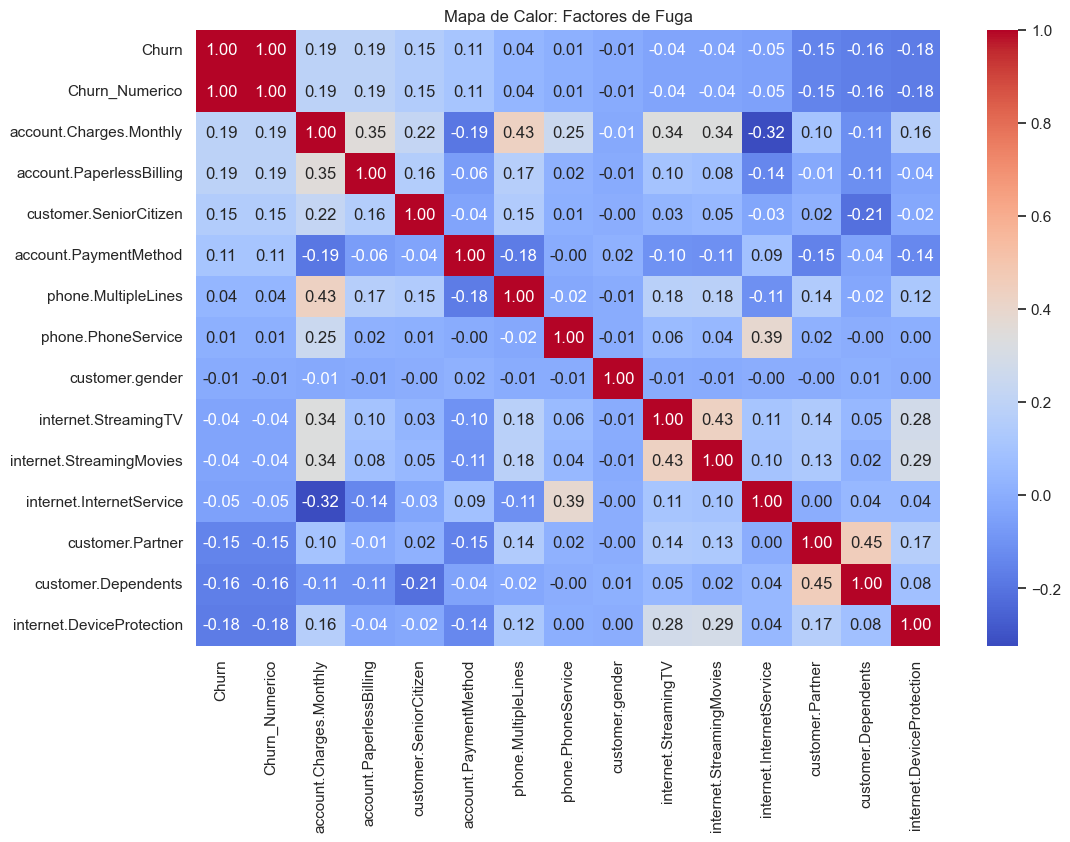

In [20]:
# CELDA 6: Matriz de Correlación (Versión A Prueba de Fallos)

plt.figure(figsize=(12, 8))

print("📊 Calculando correlaciones (ignorando texto)...")

# 1. Calculamos la correlación SOLO con columnas numéricas
# numeric_only=True es la clave para que no falle con 'Female'
corr = df.corr(numeric_only=True)['Churn_Numerico'].sort_values(ascending=False)

# 2. Mostramos el ranking en texto
print("\n🏆 TOP FACTORES DE RIESGO (¿Qué causa la fuga?):")
print(corr.head(10))

# 3. Mostramos el Mapa de Calor visual
# Filtramos las top 15 variables para que el gráfico se lea bien
top_cols = corr.index[:15]
sns.heatmap(df[top_cols].corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor: Factores de Fuga')
plt.show()

In [21]:
# CELDA 7: Entrenamiento del Modelo (Machine Learning)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. Definimos las preguntas (X) y la respuesta (y)
# X = Todo menos el ID y la columna Churn
# y = Solo la columna Churn_Numerico (La respuesta correcta)
X = df.drop(columns=['customerID', 'Churn', 'Churn_Numerico'])
y = df['Churn_Numerico']

# 2. Partir los datos (80% Entrenamiento, 20% Examen)
# random_state=42 asegura que siempre parta igual (para que sea reproducible)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"📚 Datos de estudio: {X_train.shape[0]} clientes")
print(f"📝 Datos de examen: {X_test.shape[0]} clientes")

# 3. CREAR EL CEREBRO (Random Forest)
# n_estimators=100 significa: "Crea 100 árboles de decisión y voten entre todos"
modelo = RandomForestClassifier(n_estimators=100, random_state=42)

print("\n🧠 Entrenando la IA (esto puede tardar unos segundos)...")
modelo.fit(X_train, y_train)

# 4. EL EXAMEN FINAL
# Le pedimos que prediga los resultados del 20% que nunca vio
predicciones = modelo.predict(X_test)

# Calculamos la nota
nota = accuracy_score(y_test, predicciones)
print(f"\n🏆 PRECISIÓN (ACCURACY): {nota*100:.2f}%")
print("------------------------------------------------")
print("Reporte detallado:")
print(classification_report(y_test, predicciones))

📚 Datos de estudio: 5634 clientes
📝 Datos de examen: 1409 clientes

🧠 Entrenando la IA (esto puede tardar unos segundos)...

🏆 PRECISIÓN (ACCURACY): 79.99%
------------------------------------------------
Reporte detallado:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1036
           1       0.67      0.49      0.56       373

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



In [22]:
# CELDA 8: Guardar el Modelo (Serialización)
import joblib
import os

# 1. Definimos dónde guardar (carpeta ../models)
ruta_modelos = '../models'

# Creamos la carpeta si no existe (por seguridad)
os.makedirs(ruta_modelos, exist_ok=True)

print(f"💾 Guardando artefactos en: {ruta_modelos} ...")

# 2. Guardamos el Cerebro (El modelo entrenado)
joblib.dump(modelo, f'{ruta_modelos}/churn_model.pkl')

# 3. Guardamos los Traductores (Encoders)
# Esto es VITAL: Sin esto, la API no sabrá convertir texto a números
joblib.dump(encoders, f'{ruta_modelos}/encoders.pkl')

# 4. Guardamos la lista de columnas (Metadata)
# Para asegurarnos de que la API pida los datos en el mismo orden
columnas_finales = list(X.columns)
joblib.dump(columnas_finales, f'{ruta_modelos}/model_columns.pkl')

print("✅ ¡ÉXITO TOTAL! Archivos generados:")
print(f"   1. {ruta_modelos}/churn_model.pkl")
print(f"   2. {ruta_modelos}/encoders.pkl")
print(f"   3. {ruta_modelos}/model_columns.pkl")

💾 Guardando artefactos en: ../models ...
✅ ¡ÉXITO TOTAL! Archivos generados:
   1. ../models/churn_model.pkl
   2. ../models/encoders.pkl
   3. ../models/model_columns.pkl
